# Udacity WeRateDogs Data Wrangling Project

## Introduction
This project was developed to prove the understanding of the topics covered in the **Data Wrangling** module of [Udacity Data Analyst Nanodegree](https://www.udacity.com/course/data-analyst-nanodegree--nd002).  
The main goal of the project is to use the data provided by [Twitter](https://twitter.com/) on the [WeRateDogs](https://twitter.com/dog_rates) page to create analyses and visualizations. However, as real-world data rarely comes clean, it is necessary that the student handle the possible issues in the obtained data in order to accomplish trustworthy conclusions.

In [39]:
# Necessary imports
import requests
import os
import json
import time
import tweepy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint

## Data Wrangling

In this section of the report I will gather the necessary data, understand its general properties, identify and clean possible quality and tidiness errors such as missing or incorrect values.

### Gather

Here I will be gathering each of the three pieces of data for this project.  
  
1. **WeRateDogs Twitter archive:** this file is provided by Udacity in a `.csv` file called `twitter_archive_enhanced.csv`.
2. **Image predictions:** has information about the breed of dog or object shown in the tweet photo. It is stored on Udacity's servers in the file `image_predictions.tsv`.
3. **Additional data about each tweet**: information such as the number of likes or retweets of each tweet. It can be accessed using the Twitter API with tweepy.

#### WeRateDogs Twitter Archive

In [2]:
# Converting csv file to Pandas DataFrame
twitter_archive_df = pd.read_csv('data/twitter-archive-enhanced.csv')
twitter_archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Image Predictions

In [3]:
# Getting the file from the Udacity server and saving it in the data folder
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join('data', url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

In [4]:
# Converting csv file to Pandas DataFrame
image_predictions_df = pd.read_csv('data/image-predictions.tsv', sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Additional data about each tweet

In [5]:
# Keys and tokens provided by Twitter
consumer_key = 'YOUR CONSUMER KEY HERE'
consumer_secret = 'YOUR CONSUMER SECRET HERE'
access_token = 'YOUR ACCESS TOKEN HERE'
access_secret = 'YOUR ACCESS SECRET HERE'

# Creating Twitter API object with rate limits parameters
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [6]:
# Creating empty list to store tweet data (json format)
tweet_json_list = []
# Creating empty dict to store the tweets that can't be accessed
errors_dict = {}
# Defining the start time to check how long it took to access the data
start_time = time.time()

for tweet_id in twitter_archive_df.tweet_id.values:
    try:
        # Adding tweet info to tweet_json_list
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        tweet_json_list.append(tweet._json)
    except tweepy.TweepError as error:
        # Adding tweets that could't be accessed in the errors_dict
        errors_dict[tweet_id] = error
            
# Checking how much time the was spent
elapsed_time = time.time() - start_time

# Printing elapsed time in HH:MM:SS format
hms_elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print('\n Time elapsed (HH:MM:SS): ' + hms_elapsed_time)
print('-'*55)

# Printing each tweet_id and error in the errors_dict
for tweet_id in errors_dict:
    print('ID:', tweet_id, 'ERROR:', errors_dict[tweet_id])
print('-'*55)

# Checking number of errors
print('\n Number of errors: ' + str(len(errors_dict)))

Rate limit reached. Sleeping for: 181
Rate limit reached. Sleeping for: 170



 Time elapsed (HH:MM:SS): 00:38:25
-------------------------------------------------------
ID: 888202515573088257 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 873697596434513921 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 872668790621863937 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 872261713294495745 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 869988702071779329 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 866816280283807744 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 861769973181624320 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 856602993587888130 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 851953902622658560 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 845459076796616705 ERROR: [{'code': 144, 'message': 'No status found with that ID.'}]
ID: 8447

In [7]:
# Writting tweet data to a .txt file
with open('data/tweet-json.txt', 'w') as outfile:
    for tweet_json in tweet_json_list:
        json.dump(tweet_json, outfile)
        outfile.write('\n')

In [5]:
# Creating empty list that will be used to hold fav and rt count for each tweet
tweet_extra_data_list = []

# Reading .txt file 
with open('data/tweet-json.txt', 'r') as json_file:
    # Reading first line
    line = json_file.readline()
    
    # While there's a next line execute following code
    while line:
        # Select tweet id, fav and rt count
        tweet = json.loads(line)
        tweet_id = tweet['id']
        tweet_retweet_count = tweet['retweet_count']
        tweet_favorite_count = tweet['favorite_count']
        
        # Save selected data to a dict
        tweet_data = {'tweet_id': tweet_id, 
                      'retweet_count': tweet_retweet_count, 
                      'favorite_count': tweet_favorite_count,
                     }
        
        # Add tweet_data to tweet_json_data
        tweet_extra_data_list.append(tweet_data)

        # Read next line
        line = json_file.readline()

tweet_extra_data_list[0]

{'tweet_id': 892420643555336193,
 'retweet_count': 7725,
 'favorite_count': 36279}

In [6]:
# Creating Pandas DataFrame with tweet_json_data
tweet_extra_data_df = pd.DataFrame(tweet_extra_data_list, 
                                   columns = ['tweet_id',
                                              'retweet_count',
                                              'favorite_count'])

# Creating a csv file with the extra data
tweet_extra_data_df.to_csv('data/tweet_extra_data.csv', index=False)


tweet_extra_data_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7725,36279
1,892177421306343426,5710,31278
2,891815181378084864,3785,23542
3,891689557279858688,7878,39567
4,891327558926688256,8496,37784


### Assess
The main objective of the Assess section is to better understand each piece of data and identify possible issues that must be cleaned.  
All identified issues will be listed after the assessment of the data and divided between quality and tidiness problems for each piece of data, in order to facilitate the reading of the report.

#### WeRateDogs Twitter Archive

In [7]:
# Visualizing 5 random rows
twitter_archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2061,671166507850801152,NaN,NaN,2015-11-30 03:18:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Herm. It's his first day of potty trai...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671166507...,10,10,Herm,None,None,None,None
2184,668988183816871936,NaN,NaN,2015-11-24 03:03:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Honor to rate this dog. Lots of fur on him. Tw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668988183...,7,10,None,None,None,None,None
595,798701998996647937,NaN,NaN,2016-11-16 01:39:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We normally don't rate marshmal...,7.186315e+17,4.196984e+09,2016-04-09 02:47:55 +0000,https://twitter.com/dog_rates/status/718631497...,10,10,None,None,None,None,None
495,813172488309972993,NaN,NaN,2016-12-26 00:00:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Eleanor. She winks like she knows many...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/813172488...,12,10,Eleanor,None,None,None,None
514,811627233043480576,NaN,NaN,2016-12-21 17:39:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Augie. He's a savage. Doesn't give a h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/811627233...,10,10,Augie,None,None,None,None


In [8]:
# Checking df number of rows and columns
twitter_archive_df.shape

(2356, 17)

In [9]:
# Checking df datatypes
twitter_archive_df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [10]:
# Checking missing values
twitter_archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [11]:
# I found it strange that there were None values in some columns and wanted to understand why
twitter_archive_df.query('name == "None"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None


In [12]:
# Checking name column values to see if there's any inconsistency
twitter_archive_df.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver',
       'Jim', 'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such',
       'Maya', 'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey',
       'Lilly', 'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella',
       'Grizzwald', 'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey',
       'Gary', 'a', 'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey',
       'Duddles', 'Jack', 'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow',
       'Terrance', 'Aja', 'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict',
       'Venti', 'Goose', 'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian',
       'Walter', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover',
       'Napolean', 'Dawn', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'quite', 'Dewey', 'Scout', 'Gizmo', 'Cooper', 'Harold', 'Shikha',
       'Jamesy', 'Lili', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Nept

In [13]:
# Checking tweet with a invalid dog name to better understand this possible problem
twitter_archive_df[twitter_archive_df.name == 'a'].expanded_urls.iloc[0]

'https://twitter.com/dog_rates/status/881536004380872706/video/1'

In [14]:
# Looking at the unique sources
twitter_archive_df.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [15]:
# Trying to understand what was this 'Vine - Make a Scene' value
twitter_archive_df[twitter_archive_df.source == 
                   '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'].head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
529,808344865868283904,NaN,NaN,2016-12-12 16:16:49 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Seamus. He's very bad at entering pool...,NaN,NaN,NaN,https://vine.co/v/5QWd3LZqXxd,11,10,Seamus,None,None,None,None


In [16]:
# Selecting replies that have urls so I can look at the tweet
twitter_archive_df[twitter_archive_df.in_reply_to_status_id.notnull() &
                   twitter_archive_df.expanded_urls.notnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
251,844979544864018432,7.590995e+17,4.196984e+09,2017-03-23 18:29:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",PUPDATE: I'm proud to announce that Toby is 23...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/844979544...,13,10,None,None,None,None,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,doggo,None,pupper,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [17]:
# Selecting a tweet to look
twitter_archive_df.iloc[251].expanded_urls.split(',')

['https://twitter.com/dog_rates/status/844979544864018432/photo/1',
 'https://twitter.com/dog_rates/status/844979544864018432/photo/1',
 'https://twitter.com/dog_rates/status/844979544864018432/photo/1']

In [18]:
# Checking for tweets that doesn't have urls linked
twitter_archive_df[twitter_archive_df.in_reply_to_status_id.isnull() &
                   twitter_archive_df.retweeted_status_user_id.isnull() &
                   twitter_archive_df.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [19]:
# Checking doggo unique values to understand the dog stages columns
twitter_archive_df.doggo.unique()

array(['None', 'doggo'], dtype=object)

In [20]:
# Checking descriptive statistics
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [21]:
# Checking tweets that have a rating_numerator of 0, because it is strange for a dog page
twitter_archive_df.query('rating_numerator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


In [22]:
# Checking tweets that have a rating_numerator of 1776, because it is definitely a notable value
twitter_archive_df.query('rating_numerator == 1776')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [23]:
# Checking tweets that have a rating_denominator of 0, because it doesn't follow the page's rating pattern
twitter_archive_df.query('rating_denominator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


#### Image Predictions

In [24]:
# Visualizing 5 random rows
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
678,683498322573824003,https://pbs.twimg.com/media/CXxGGOsUwAAr62n.jpg,1,Airedale,0.945362,True,Irish_terrier,0.026850,True,Lakeland_terrier,0.016826,True
191,669564461267722241,https://pbs.twimg.com/media/CUrFUvDVAAA9H-F.jpg,1,toy_poodle,0.623685,True,miniature_poodle,0.259920,True,standard_poodle,0.082530,True
41,666701168228331520,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,1,Labrador_retriever,0.887707,True,Chihuahua,0.029307,True,French_bulldog,0.020756,True
1484,781524693396357120,https://pbs.twimg.com/media/CtiIj0AWcAEBDvw.jpg,1,tennis_ball,0.994712,False,Chesapeake_Bay_retriever,0.003523,True,Labrador_retriever,0.000921,True
1259,748699167502000129,https://pbs.twimg.com/media/CmPp5pOXgAAD_SG.jpg,1,Pembroke,0.849029,True,Cardigan,0.083629,True,kelpie,0.024394,True


In [25]:
# Checking image_predictions shape
image_predictions_df.shape

(2075, 12)

In [26]:
# Checking columns data types
image_predictions_df.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

In [27]:
# Looking for missing values
image_predictions_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [28]:
# Checking some photos to better understand the predictions
print(image_predictions_df.iloc[1037].jpg_url)
print(image_predictions_df.iloc[442].jpg_url)
print(image_predictions_df.iloc[293].jpg_url)
print(image_predictions_df.iloc[1480].jpg_url)

https://pbs.twimg.com/tweet_video_thumb/CeGGkWuUUAAYWU1.jpg
https://pbs.twimg.com/media/CVzG3yOVAAAqi9I.jpg
https://pbs.twimg.com/media/CVEbFDRWsAAkN_7.jpg
https://pbs.twimg.com/media/CtYqeNHWgAATqYZ.jpg


In [29]:
# Looking for inconsistencies in p1 values
image_predictions_df.p1.unique()[:30]

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier'], dtype=object)

In [30]:
# Looking for inconsistencies in p2 values
image_predictions_df.p2.unique()[:30]

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow'], dtype=object)

#### Additional data

In [31]:
# Visualizing 5 random rows
tweet_extra_data_df.sample(5)

,tweet_id,retweet_count,favorite_count
1338,703041949650034688,12459,26284
241,844979544864018432,2534,13560
1950,672997845381865473,686,1901
1161,718613305783398402,478,2419
21,887517139158093824,10760,43564


In [32]:
# Checking tweet_extra_data_df shape
tweet_extra_data_df.shape

(2331, 3)

In [33]:
# Checking columns data types
tweet_extra_data_df.dtypes

tweet_id          int64
retweet_count     int64
favorite_count    int64
dtype: object

In [34]:
# Looking for missing values 
tweet_extra_data_df.isnull().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [35]:
# Creating a variable for 10 random rows with 0 favorites
zero_favs_sample = tweet_extra_data_df.query('favorite_count == 0').head(10)
zero_favs_sample

,tweet_id,retweet_count,favorite_count
31,886054160059072513,100,0
35,885311592912609280,16927,0
67,879130579576475649,6230,0
72,878404777348136964,1180,0
73,878316110768087041,6104,0
77,877611172832227328,73,0
90,874434818259525634,13374,0
95,873337748698140672,1473,0
105,871166179821445120,5290,0
119,868639477480148993,1938,0


In [36]:
# Checking url for the tweets that supposedly have zero favorites to verify if that's right
zero_favs_sample_ids = zero_favs_sample.tweet_id.values
for tweet_id in zero_favs_sample_ids:
    print(twitter_archive_df[twitter_archive_df['tweet_id'] == tweet_id].expanded_urls.values)

['https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873']
['https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1']
['https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1']
['https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1']
['https://twitter.com/dog_rates/status/669000397445533696/photo/1']
['https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1']
['https://twitter.com/dog_rates/status/866334964761202691/p

In [37]:
# Checking how many tweets supposedly have zero likes
len(tweet_extra_data_df.query('favorite_count == 0'))

163

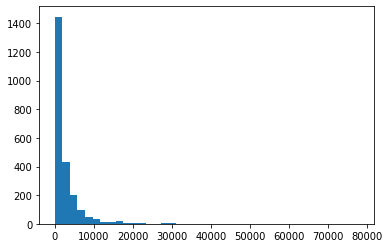

In [44]:
# Checking retweet_count distribution
plt.hist(tweet_extra_data_df.retweet_count, bins=40);

In [67]:
# Checking retweet_count interquartile range
tweet_extra_data_df.retweet_count.quantile([0.25, 0.75])

0.25     548.5
0.75    3148.0
Name: retweet_count, dtype: float64

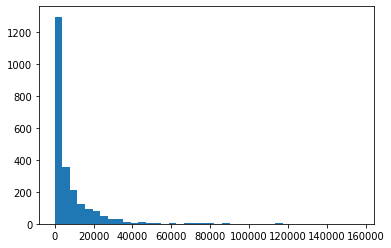

In [45]:
# Checking favorite_count distribution
plt.hist(tweet_extra_data_df.favorite_count, bins=40);

In [87]:
# Checking favorite_count third quartile
tweet_extra_data_df.favorite_count.quantile(0.75)

9271.5

In [85]:
"""
Checking fifteenth percentile of (favorite_count / retweet_count). 
It's important to notice that there's 161 tweets with 0 favorites, 
which represents approximately 7% of the tweets.
"""
(tweet_extra_data_df.favorite_count / tweet_extra_data_df.retweet_count).quantile(0.15)

2.091008437877486

#### Quality issues observed
`WeRateDogs Twitter Archive`:
1. IDs columns are floats not integers.
2. Timestamp is a string not a datetime object.
3. Source should be cleaned to make it more readable.
4. Incorret URLs (leads to another tweet's page, nonexistent page, or has several URLs).
5. Name column has invalid values like 'a', 'one', 'in', for example.
6. Missing data (tweets that doesn't have urls linked).

`Image Predictions`:
1. Some strings are lowercase and some aren't in columns p1, p2, p3.
2. There are only 2075 image predictions, 281 less than the number of tweets in the WeRateDogs Archive.

`Tweets Extra Data`:
1. There are 31 tweets from the original archive that couldn't be accessed using tweepy (TweepError).
2. There are 163 tweets that have zero favorites in the favorite_count column.

#### Tidiness issues observed
1. All replies and retweets must be dropped from the WeRateDogs Archive, according to Udacity's instructions on the scope of the project:
> "You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets."
2. After dropping replies and retweets, there's no use of retweets and replies related columns in the `twitter_archive_df`.
3. Dog stages (`doggo`, `floof`, `pupper`, `pupper`) should be organized in a single column in the `twitter_archive_df`.
4. `retweet_count` and `favorite_count` columns from the `tweet_extra_data_df` should be in the `twitter_archive_df`.
5. There should only be two tables, one with all the information regarding the tweet and the other with all the information regarding the dogs presented in each tweet.

### Clean
Here I will be defining and executing programmatic solutions for each identified issue in the Assess section, as well as testing whether the proposed solution solved the problem or not.

#### Define
Defining how I will solve the observed issues.

##### Quality Issues 

`WeRateDogs Twitter Archive`:
1. Use the pandas [astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.astype.html) method to convert column values to integers.
2. Use the pandas [to_datetime()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) method to convert column values to datetime.
3. Select only the text between ">" and "<".
4. Replace the URL column values with **"https://<span></span>twitter.com/dog_rates/status/"** + **the row's tweet ID**.
5. Replace invalid dog names with "None". Although some tweets actually have the dog's name in their text, this will be a plausible solution since those tweets represent a very small portion of the data and the dog names will not be used in further analyzes in this project.
6. This will actually be solved when I deal with the wrong or multiple URLs problem.

`Image Predictions`:
1. Use the pandas [str.lower()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.lower.html) method to lowercase strings in each column.
2. Drop tweets in the **Twitter Archive** that were published before August 1st, 2017, according to Udacity's instructions on the scope of the project:
> "You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used."

`Tweets Extra Data`:
1. Since I'll join the number of favorites and retweets in the tweets archive table, the tweets that could not be accessed will have NaN values in the **favorite_count** and **retweet_count** columns. The favorites count column will be filled along with the tweets that have zero favorites (incorrect values), while the retweets count column will be filled by randomly selecting a number inside the [interquartile range](https://www.statisticshowto.com/probability-and-statistics/interquartile-range/) with the [random](https://docs.python.org/3/library/random.html) **randint()** method, to ensure that the [measures of central tendency](https://statisticsbyjim.com/basics/measures-central-tendency-mean-median-mode/) do not suffer significant variations.
2. All tweets with missing or incorrect data (zero favorites) will be filled with a random selection of an integer (**randint()** method) between **2 times the number of retweets in the tweet** and the **third quartile** (docs for quartiles [here](https://en.wikipedia.org/wiki/Quartile)), this will not only ensure that the [measures of central tendency](https://statisticsbyjim.com/basics/measures-central-tendency-mean-median-mode/) do not suffer large variations, but also that the number of favorites is not less than 2 times the number of retweets, which is highly unlikely. In the case that number of retweets times 2 is greater than the third quartile of the number of favorites, the assigned value will be 1.75 times the number of retweets, aiming to minimize oscillations in the measures of central tendency.

##### TIdiness Issues

1. Drop all rows that have values in the replies or retweets columns.
2. Drop replies and retweets columns.
3. Create `dog_stage` column using the information of the dog stages columns. When there's no assigned stage, `dog_stage` column value should be "none".
4. Merge **tweet extra data** with the **Twitter archive** on tweet ID.
5. Separate the data into two tables, one called `dogs_df` and the other called` tweets_df`.

#### Code
Solve the problems

#### Test
Test if your code worked

## Exploratory Data Analysis
Explain EDA

## Conclusion

Write conclusions